#### Required Libraries.

In [5]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn import neighbors
import matplotlib.pyplot as plt
%matplotlib inline
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing, linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

#### Read data.

In [7]:
data = pd.read_csv("nyc_taxi_trip_duration.csv") # Reading data using pandas.
data.head()                                      # Displays the first 5 rows of the dataset.

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


#### Data cleaning.
##### Therefore no null values and missing values are present.

In [8]:
data.isnull().sum() #Display the count of null or missing values in the dataset.

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [9]:
data = data.loc[data['trip_duration']<1000000]  # Data less than 1000000 is taken for training. 

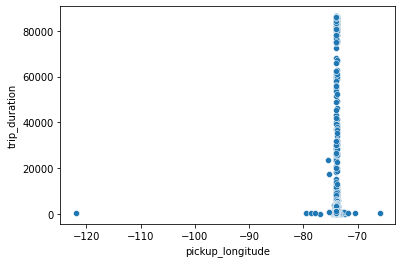

In [10]:
# Relationship between pickup_longitude and trip_duration.
sns.scatterplot(x='pickup_longitude',y='trip_duration',data=data)
plt.show()

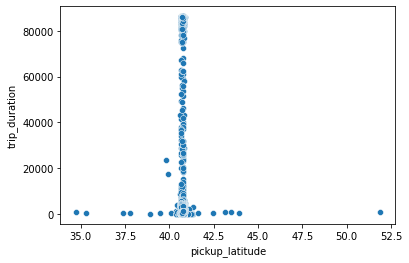

In [11]:
# Relationship between pickup_latitude and trip_duration.
sns.scatterplot(x='pickup_latitude',y='trip_duration',data=data)
plt.show()

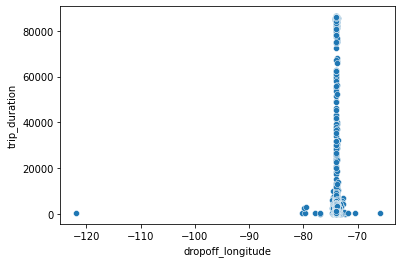

In [12]:
# Relationship between dropoff_longitude and trip_duration.
sns.scatterplot(x='dropoff_longitude',y='trip_duration',data=data)
plt.show()

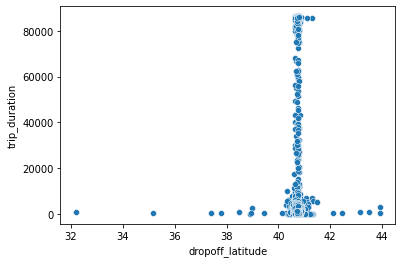

In [13]:
# Relationship between dropoff_latitude and trip_duration.
sns.scatterplot(x='dropoff_latitude',y='trip_duration',data=data)
plt.show()

#### Dropping the rows that has passenger ocunt = 0.

In [14]:
data = data.loc[data['passenger_count']!=0] # Dropping the rows that has passenger count equal to zero.

#### Data reduction.

In [15]:
# Dropping the unwanted features.
data.drop('id', axis = 1, inplace = True)
data.drop('dropoff_datetime', inplace=True, axis=1)

In [16]:
# Converting pickup_datetime into datatime format using pandas.
data["pickup_datetime"]=pd.to_datetime(data["pickup_datetime"])

In [17]:
# Extracting the day of the week from datatime column as a new feature.
data['day_of_week'] = data['pickup_datetime'].dt.day_name()

In [18]:
# Extracting the hour and month from datatime column as a new features.
data['hour_of_the_day']=data['pickup_datetime'].dt.hour
data['month']=data['pickup_datetime'].dt.month

In [19]:
# Encoding the feature day_of_week and store_and_fwd_flag
data['day_of_week']=data['day_of_week'].map({'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7})
data['store_and_fwd_flag']=data['store_and_fwd_flag'].map({'N':0,'Y':1})
data

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,day_of_week,hour_of_the_day,month
0,2,2016-02-29 16:40:21,1,-73.953918,40.778873,-73.963875,40.771164,0,400,1,16,2
1,1,2016-03-11 23:35:37,2,-73.988312,40.731743,-73.994751,40.694931,0,1100,5,23,3
2,2,2016-02-21 17:59:33,2,-73.997314,40.721458,-73.948029,40.774918,0,1635,7,17,2
3,2,2016-01-05 09:44:31,6,-73.961670,40.759720,-73.956779,40.780628,0,1141,2,9,1
4,1,2016-02-17 06:42:23,1,-74.017120,40.708469,-73.988182,40.740631,0,848,3,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...
729317,2,2016-05-21 13:29:38,2,-73.965919,40.789780,-73.952637,40.789181,0,296,6,13,5
729318,1,2016-02-22 00:43:11,1,-73.996666,40.737434,-74.001320,40.731911,0,315,1,0,2
729319,1,2016-04-15 18:56:48,1,-73.997849,40.761696,-74.001488,40.741207,0,673,5,18,4
729320,1,2016-06-19 09:50:47,1,-74.006706,40.708244,-74.013550,40.713814,0,447,7,9,6


#### Haversine - The haversine distance is also called as Great circle distance. It is used to calculate the distance between two points in a sphere using their geocodes (set of latitudes and longitudes).

In [20]:
def haversine(lat1, lon1, lat2, lon2):
    # distance between latitudes and longitudes
    dLat = (lat2 - lat1) * math.pi / 180.0
    dLon = (lon2 - lon1) * math.pi / 180.0
 
    # convert to radians
    lat1 = (lat1) * math.pi / 180.0
    lat2 = (lat2) * math.pi / 180.0
 
    # apply formulae
    a = (pow(math.sin(dLat / 2), 2) +
         pow(math.sin(dLon / 2), 2) *
             math.cos(lat1) * math.cos(lat2));
    rad = 6371
    c = 2 * math.asin(math.sqrt(a))
    return rad * c

In [21]:
# Calculating the distance between two points in a sphere using the geocodes.
data['distance']=data.apply(lambda row:haversine(row['pickup_latitude'],row['pickup_longitude'],row['dropoff_latitude'],row['dropoff_longitude']),axis=1)
data['distance']=data['distance'].astype(float)

In [22]:
# Dropping the columns since these are made into new feature named distance.
data.drop('pickup_longitude',inplace=True,axis=1)
data.drop('pickup_latitude',inplace=True,axis=1)
data.drop('dropoff_longitude',inplace=True,axis=1)
data.drop('dropoff_latitude',inplace=True,axis=1)
data.drop('pickup_datetime',inplace=True,axis=1)

In [23]:
data

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,day_of_week,hour_of_the_day,month,distance
0,2,1,0,400,1,16,2,1.199073
1,1,2,0,1100,5,23,3,4.129111
2,2,2,0,1635,7,17,2,7.250753
3,2,6,0,1141,2,9,1,2.361097
4,1,1,0,848,3,6,2,4.328534
...,...,...,...,...,...,...,...,...
729317,2,2,0,296,6,13,5,1.120223
729318,1,1,0,315,1,0,2,0.728705
729319,1,1,0,673,5,18,4,2.298776
729320,1,1,0,447,7,9,6,0.846316


#### Data transformation.

C:\Users\Sai Ganesh Yadav\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


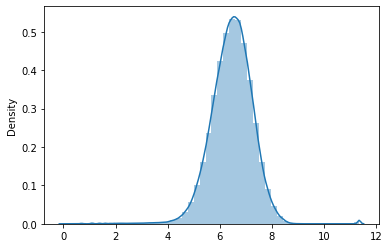

In [24]:
# Visualizing log transformation of trip_duration.
sns.distplot(np.log(data['trip_duration'].values))
plt.show()

In [25]:
# Log transformation.
data['trip_duration']=np.log(data['trip_duration'])

In [26]:
# Data after log transformation.
data

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,day_of_week,hour_of_the_day,month,distance
0,2,1,0,5.991465,1,16,2,1.199073
1,1,2,0,7.003065,5,23,3,4.129111
2,2,2,0,7.399398,7,17,2,7.250753
3,2,6,0,7.039660,2,9,1,2.361097
4,1,1,0,6.742881,3,6,2,4.328534
...,...,...,...,...,...,...,...,...
729317,2,2,0,5.690359,6,13,5,1.120223
729318,1,1,0,5.752573,1,0,2,0.728705
729319,1,1,0,6.511745,5,18,4,2.298776
729320,1,1,0,6.102559,7,9,6,0.846316


#### Data preparation.

In [27]:
X = data.drop('trip_duration', axis = 1)
X

,vendor_id,passenger_count,store_and_fwd_flag,day_of_week,hour_of_the_day,month,distance
0,2,1,0,1,16,2,1.199073
1,1,2,0,5,23,3,4.129111
2,2,2,0,7,17,2,7.250753
3,2,6,0,2,9,1,2.361097
4,1,1,0,3,6,2,4.328534
...,...,...,...,...,...,...,...
729317,2,2,0,6,13,5,1.120223
729318,1,1,0,1,0,2,0.728705
729319,1,1,0,5,18,4,2.298776
729320,1,1,0,7,9,6,0.846316


In [28]:
y = data['trip_duration']
y

0         5.991465
1         7.003065
2         7.399398
3         7.039660
4         6.742881
            ...   
729317    5.690359
729318    5.752573
729319    6.511745
729320    6.102559
729321    7.109879
Name: trip_duration, Length: 729288, dtype: float64

#### Train and test data split.

In [29]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

### 1) Most suitable performance metrics:
    i) Root mean square error(MSE) - The square root of the mean of the square of all of the error. 
    ii) R2 score - Coefficient of determination - Statistical measure in a regression model that determines the proportion of variance in the dependent variable that can be explained by the independent variable
    
    I have used the above two performance metrics to evaluate the performance of the model. I chose the above two because RMSE gives the difference between the actual and predicted values and r2 score the proportion of variance in dependent variable can be explained by the independent variable.

#### 2) Bench mark model for the given dataset - LBGM.

In [30]:
LBGM = LGBMRegressor(n_estimators=500)  #n_estimators (int, optional (default=100)) – Number of boosted trees to fit.
LBGM.fit(x_train,y_train)

LGBMRegressor(n_estimators=500)

In [31]:
pred_LBGM=LBGM.predict(x_test) #make prediction on test set
LBGM_error = math.sqrt(mean_squared_error(y_test,pred_LBGM)) #calculate rmse
r2_LBGM = r2_score(y_test,pred_LBGM) # calculate r2_score

In [32]:
print("RMSE value for LBGM regressor = ", LBGM_error, "\n" , "R2 score = ", r2_LBGM) # R2 value and RMSE value

RMSE value for LBGM regressor =  0.46387748832591436 
 R2 score =  0.6618849459893175


In [33]:
# Train and test score
LBGM_score_test = LBGM.score(x_test, y_test) # Testscore
LBGM_score_train = LBGM.score(x_train, y_train) # Trainscore
print("Train Score for LBGM Regressor :", LBGM_score_train)
print("Test Score for LBGM Regressor :", LBGM_score_test)

Train Score for LBGM Regressor : 0.6769561949139807
Test Score for LBGM Regressor : 0.6618849459893175


#### 3) KNN.

In [34]:
rmse_val = [] #to store rmse values for different k
for K in range(50):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train, y_train)  #fit the model
    pred=model.predict(x_test) #make prediction on test set
    error = math.sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.6541034357332504
RMSE value for k=  2 is: 0.5673664272210477
RMSE value for k=  3 is: 0.5360682869328449
RMSE value for k=  4 is: 0.5214383589595616
RMSE value for k=  5 is: 0.5123645122231165
RMSE value for k=  6 is: 0.5060367805650157
RMSE value for k=  7 is: 0.5016521767223913
RMSE value for k=  8 is: 0.4982815326156235
RMSE value for k=  9 is: 0.49603937345404886
RMSE value for k=  10 is: 0.49421341429337684
RMSE value for k=  11 is: 0.49283407261268997
RMSE value for k=  12 is: 0.4916381926333301
RMSE value for k=  13 is: 0.49067202981552754
RMSE value for k=  14 is: 0.48983883019938895
RMSE value for k=  15 is: 0.489191019937315
RMSE value for k=  16 is: 0.48842536799586306
RMSE value for k=  17 is: 0.48808181214980273
RMSE value for k=  18 is: 0.48759251878191795
RMSE value for k=  19 is: 0.487164239268184
RMSE value for k=  20 is: 0.48678449200536156
RMSE value for k=  21 is: 0.4864837384012593
RMSE value for k=  22 is: 0.48623755129182245
RMSE value 

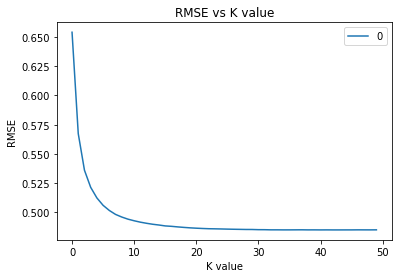

In [36]:
# Plot that represent the RMSE with varying K - values.
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()
plt.xlabel("K value")
plt.ylabel('RMSE')
plt.title("RMSE vs K value")
plt.show()

#### The best k value = 33.

In [37]:
model_knn = neighbors.KNeighborsRegressor(n_neighbors = 33) 
model_knn.fit(x_train,y_train) # fitting the model
pred_knn=model_knn.predict(x_test) # make prediction on test set
knn_error = math.sqrt(mean_squared_error(y_test,pred_knn)) # Root mean squared error

In [38]:
r2 = r2_score(y_test,pred_knn)
print("RMS value for KNN = ", knn_error, "\n" , "R2 score = ", r2) # R2 value and RMSE value

RMS value for KNN =  0.4850791971208672 
 R2 score =  0.6302712575866176


#### Train and test score for KNN.

In [41]:
# Train and test score
knn_score_test = model_knn.score(x_test, y_test) # Testscore
knn_score_train = model_knn.score(x_train, y_train) # Trainscore
print("Train Score for KNN :", knn_score_train)
print("Test Score for KNN :", knn_score_test)

Train Score for KNN : 0.6492577683525083
Test Score for KNN : 0.6302712575866176


#### 4) Linear model with regularization.

In [42]:
# create linear model object
reg = linear_model.Ridge(alpha=.5)
# train the model using the training sets
reg.fit(x_train, y_train)

Ridge(alpha=0.5)

In [43]:
# regression coefficients
print('Coefficients: ', reg.coef_)

Coefficients:  [ 0.01837008  0.0078205   0.01163001 -0.01170946  0.00572688  0.01786244
  0.10154825]


In [44]:
# variance score: 1 means perfect prediction
print('Variance score: {}'.format(reg.score(x_test, y_test)))

Variance score: 0.3391157034829252


In [45]:
# the intercept
reg.intercept_

5.980633274696977

#### Residual plot.

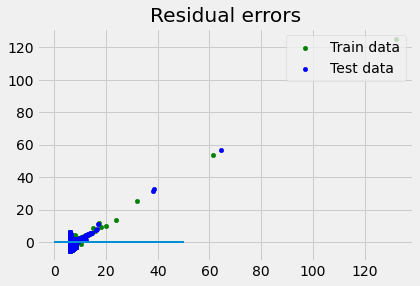

In [46]:
# plot for residual error
  
## setting plot style
plt.style.use('fivethirtyeight')
  
## plotting residual errors in training data
plt.scatter(reg.predict(x_train), reg.predict(x_train) - y_train,
            color = "green", s = 20, label = 'Train data')
  
## plotting residual errors in test data
plt.scatter(reg.predict(x_test), reg.predict(x_test) - y_test,
            color = "blue", s = 20, label = 'Test data')
  
## plotting line for zero residual error
plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)
  
## plotting legend
plt.legend(loc = 'upper right')
  
## plot title
plt.title("Residual errors")
  
## method call for showing the plot
plt.show()

In [47]:
pred_linear=reg.predict(x_test) #make prediction on test set
reg_error = math.sqrt(mean_squared_error(y_test,pred_linear)) #calculate rmse
r2_linear = r2_score(y_test,pred_linear)
print("RMS value for Linear regression = ", reg_error, "\n" , "R2 score = ", r2_linear) # R2 value and RMSE value

RMS value for Linear regression =  0.6485355086328372 
 R2 score =  0.3391157034829252


In [48]:
# Train and test score
reg_score_test = reg.score(x_test, y_test) # Testscore
reg_score_train = reg.score(x_train, y_train) # Trainscore
print("Train Score for linear regression:", reg_score_train)
print("Test Score for linear regression :", reg_score_test)

Train Score for linear regression: 0.31715913337279267
Test Score for linear regression : 0.3391157034829252


#### 5) Decision tree.

In [49]:
# Base model.
dtm = DecisionTreeRegressor(max_depth=4, min_samples_split=5, max_leaf_nodes=10) 
dtm.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=4, max_leaf_nodes=10, min_samples_split=5)

In [50]:
parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,],
           "min_samples_leaf":[1,2,3,4],
           "min_weight_fraction_leaf":[0.1,0.2,0.3],
           "max_features":["auto","log2","sqrt"],
           "max_leaf_nodes":[10,20,30,40] }

In [51]:
# Hpyer paramter tuning.
tuning_model=GridSearchCV(dtm,param_grid=parameters,scoring='r2',cv=2,verbose=3) # Grid search CV method.
tuning_model.fit(x_train,y_train) 

Fitting 2 folds for each of 864 candidates, totalling 1728 fits
[CV 1/2] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.379 total time=   0.3s
[CV 2/2] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.375 total time=   0.2s
[CV 1/2] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=0.002 total time=   0.1s
[CV 2/2] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=0.001 total time=   0.1s
[CV 1/2] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=0.379 total time=   0.3s
[CV 2/2] END max_depth=1, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best

[CV 2/2] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=0.003 total time=   0.1s
[CV 1/2] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=0.379 total time=   0.2s
[CV 2/2] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=0.375 total time=   0.3s
[CV 1/2] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=0.001 total time=   0.1s
[CV 2/2] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=0.004 total time=   0.1s
[CV 1/2] END max_depth=1, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=0.379 total time=   0.2s
[CV 2/2] END max_depth=1, ma

[CV 1/2] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=0.003 total time=   0.1s
[CV 2/2] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=0.002 total time=   0.1s
[CV 1/2] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=0.379 total time=   0.2s
[CV 2/2] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=0.375 total time=   0.2s
[CV 1/2] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=0.002 total time=   0.1s
[CV 2/2] END max_depth=1, max_features=auto, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=0.002 total time=   0.1s
[CV 1/2] END max_depth=1, 

[CV 2/2] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=0.375 total time=   0.2s
[CV 1/2] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=0.002 total time=   0.1s
[CV 2/2] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=0.002 total time=   0.1s
[CV 1/2] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.379 total time=   0.2s
[CV 2/2] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.375 total time=   0.2s
[CV 1/2] END max_depth=1, max_features=auto, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=0.002 total time=   0.1s
[CV 2/2] END max_depth=1, ma

[CV 1/2] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.006 total time=   0.1s
[CV 2/2] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.002 total time=   0.1s
[CV 1/2] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=0.000 total time=   0.1s
[CV 2/2] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=0.006 total time=   0.1s
[CV 1/2] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best;, score=0.003 total time=   0.1s
[CV 2/2] END max_depth=1, max_features=log2, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best;, score=0.375 total time=   0.1s
[CV 1/2] END max_depth=1, max_

[CV 1/2] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best;, score=0.005 total time=   0.1s
[CV 2/2] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best;, score=0.005 total time=   0.1s
[CV 1/2] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random;, score=-0.000 total time=   0.1s
[CV 2/2] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random;, score=-0.000 total time=   0.1s
[CV 1/2] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=0.002 total time=   0.1s
[CV 2/2] END max_depth=1, max_features=log2, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=0.375 total time=   0.2s
[CV 1/2] END max_depth=1, ma

[CV 1/2] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random;, score=0.000 total time=   0.1s
[CV 2/2] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random;, score=0.000 total time=   0.1s
[CV 1/2] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=0.003 total time=   0.1s
[CV 2/2] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=-0.000 total time=   0.1s
[CV 1/2] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-0.000 total time=   0.1s
[CV 2/2] END max_depth=1, max_features=log2, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=-0.000 total time=   0.1s
[CV 1/2] END max_depth=

[CV 2/2] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=0.002 total time=   0.1s
[CV 1/2] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=0.001 total time=   0.1s
[CV 2/2] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=0.000 total time=   0.1s
[CV 1/2] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.002 total time=   0.1s
[CV 2/2] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.001 total time=   0.1s
[CV 1/2] END max_depth=1, max_features=log2, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=0.002 total time=   0.1s
[CV 2/2] END max_depth=1, ma

[CV 1/2] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.006 total time=   0.1s
[CV 2/2] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.003 total time=   0.1s
[CV 1/2] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=0.004 total time=   0.1s
[CV 2/2] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=0.001 total time=   0.1s
[CV 1/2] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=0.002 total time=   0.1s
[CV 2/2] END max_depth=1, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=0.003 total time=   0.1s
[CV 1/2] END max_depth=1, max_

[CV 2/2] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=0.000 total time=   0.1s
[CV 1/2] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=0.003 total time=   0.1s
[CV 2/2] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=0.375 total time=   0.2s
[CV 1/2] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=0.000 total time=   0.1s
[CV 2/2] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=0.002 total time=   0.1s
[CV 1/2] END max_depth=1, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=0.379 total time=   0.2s
[CV 2/2] END max_depth=1, ma

[CV 1/2] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=0.002 total time=   0.1s
[CV 2/2] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-0.000 total time=   0.1s
[CV 1/2] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=0.003 total time=   0.1s
[CV 2/2] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=0.002 total time=   0.1s
[CV 1/2] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=0.000 total time=   0.1s
[CV 2/2] END max_depth=1, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=0.000 total time=   0.1s
[CV 1/2] END max_depth=1,

[CV 2/2] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=0.001 total time=   0.1s
[CV 1/2] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=-0.000 total time=   0.1s
[CV 2/2] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=0.002 total time=   0.1s
[CV 1/2] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.379 total time=   0.2s
[CV 2/2] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.003 total time=   0.1s
[CV 1/2] END max_depth=1, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=0.000 total time=   0.1s
[CV 2/2] END max_depth=1, m

[CV 1/2] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.547 total time=   0.4s
[CV 2/2] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.543 total time=   0.5s
[CV 1/2] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=0.227 total time=   0.2s
[CV 2/2] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=0.008 total time=   0.2s
[CV 1/2] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=0.523 total time=   0.4s
[CV 2/2] END max_depth=3, max_features=auto, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=0.521 total time=   0.4s
[CV 1/2] END max_depth=3, max_

[CV 2/2] END max_depth=3, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=0.008 total time=   0.2s
[CV 1/2] END max_depth=3, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=0.523 total time=   0.4s
[CV 2/2] END max_depth=3, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=0.521 total time=   0.3s
[CV 1/2] END max_depth=3, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=0.004 total time=   0.2s
[CV 2/2] END max_depth=3, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=0.002 total time=   0.2s
[CV 1/2] END max_depth=3, max_features=auto, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=0.379 total time=   0.2s
[CV 2/2] END max_depth=3, ma

[CV 1/2] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=0.005 total time=   0.1s
[CV 2/2] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=0.002 total time=   0.1s
[CV 1/2] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=0.379 total time=   0.2s
[CV 2/2] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=0.375 total time=   0.2s
[CV 1/2] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=0.002 total time=   0.1s
[CV 2/2] END max_depth=3, max_features=auto, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=0.002 total time=   0.1s
[CV 1/2] END max_depth=3, 

[CV 2/2] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=0.375 total time=   0.2s
[CV 1/2] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=0.000 total time=   0.1s
[CV 2/2] END max_depth=3, max_features=auto, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=0.002 total time=   0.2s
[CV 1/2] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.201 total time=   0.2s
[CV 2/2] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.010 total time=   0.2s
[CV 1/2] END max_depth=3, max_features=log2, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=-0.000 total time=   0.1s
[CV 2/2] END max_depth=3, m

[CV 1/2] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.462 total time=   0.3s
[CV 2/2] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.237 total time=   0.2s
[CV 1/2] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=0.002 total time=   0.1s
[CV 2/2] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=-0.000 total time=   0.1s
[CV 1/2] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=0.380 total time=   0.2s
[CV 2/2] END max_depth=3, max_features=log2, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=0.008 total time=   0.2s
[CV 1/2] END max_depth=3, max

[CV 2/2] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=0.002 total time=   0.1s
[CV 1/2] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=0.010 total time=   0.1s
[CV 2/2] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=0.007 total time=   0.1s
[CV 1/2] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=0.002 total time=   0.1s
[CV 2/2] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=0.000 total time=   0.1s
[CV 1/2] END max_depth=3, max_features=log2, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=0.379 total time=   0.2s
[CV 2/2] END max_depth=3, ma

[CV 1/2] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=0.002 total time=   0.1s
[CV 2/2] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-0.000 total time=   0.1s
[CV 1/2] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=0.003 total time=   0.1s
[CV 2/2] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=0.000 total time=   0.1s
[CV 1/2] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-0.000 total time=   0.1s
[CV 2/2] END max_depth=3, max_features=log2, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-0.000 total time=   0.1s
[CV 1/2] END max_depth=

[CV 1/2] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=0.001 total time=   0.1s
[CV 2/2] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=0.375 total time=   0.1s
[CV 1/2] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=0.002 total time=   0.1s
[CV 2/2] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=-0.000 total time=   0.1s
[CV 1/2] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.157 total time=   0.2s
[CV 2/2] END max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.456 total time=   0.3s
[CV 1/2] END max_depth=3, max

[CV 1/2] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=0.000 total time=   0.1s
[CV 2/2] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=random;, score=0.000 total time=   0.1s
[CV 1/2] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.227 total time=   0.2s
[CV 2/2] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.523 total time=   0.3s
[CV 1/2] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=0.005 total time=   0.1s
[CV 2/2] END max_depth=3, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=0.002 total time=   0.1s
[CV 1/2] END max_depth=3, 

[CV 2/2] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=best;, score=0.200 total time=   0.1s
[CV 1/2] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=0.000 total time=   0.1s
[CV 2/2] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.1, splitter=random;, score=0.000 total time=   0.1s
[CV 1/2] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best;, score=0.010 total time=   0.1s
[CV 2/2] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best;, score=0.005 total time=   0.1s
[CV 1/2] END max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random;, score=0.006 total time=   0.1s
[CV 2/2] END max_depth=3, ma

[CV 1/2] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best;, score=0.003 total time=   0.1s
[CV 2/2] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=best;, score=0.004 total time=   0.2s
[CV 1/2] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random;, score=0.000 total time=   0.1s
[CV 2/2] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random;, score=0.000 total time=   0.1s
[CV 1/2] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=0.379 total time=   0.2s
[CV 2/2] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=0.002 total time=   0.1s
[CV 1/2] END max_depth=3, max_

[CV 2/2] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.2, splitter=random;, score=0.003 total time=   0.1s
[CV 1/2] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=0.379 total time=   0.2s
[CV 2/2] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=best;, score=0.375 total time=   0.2s
[CV 1/2] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=0.002 total time=   0.1s
[CV 2/2] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=0.000 total time=   0.1s
[CV 1/2] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.547 total time=   0.5s
[CV 2/2] END max_depth=5, ma

[CV 1/2] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=0.002 total time=   0.1s
[CV 2/2] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=2, min_weight_fraction_leaf=0.3, splitter=random;, score=0.002 total time=   0.2s
[CV 1/2] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.547 total time=   0.5s
[CV 2/2] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.543 total time=   0.6s
[CV 1/2] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=0.011 total time=   0.2s
[CV 2/2] END max_depth=5, max_features=auto, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=0.005 total time=   0.2s
[CV 1/2] END max_depth=5, 

[CV 2/2] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=best;, score=0.543 total time=   0.5s
[CV 1/2] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=0.380 total time=   0.3s
[CV 2/2] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.1, splitter=random;, score=0.006 total time=   0.3s
[CV 1/2] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=0.523 total time=   0.4s
[CV 2/2] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=0.521 total time=   0.5s
[CV 1/2] END max_depth=5, max_features=auto, max_leaf_nodes=30, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=0.004 total time=   0.2s
[CV 2/2] END max_depth=5, ma

[CV 1/2] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=0.523 total time=   0.4s
[CV 2/2] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=best;, score=0.521 total time=   0.4s
[CV 1/2] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=0.002 total time=   0.2s
[CV 2/2] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=0.005 total time=   0.1s
[CV 1/2] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=0.379 total time=   0.2s
[CV 2/2] END max_depth=5, max_features=auto, max_leaf_nodes=40, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=0.375 total time=   0.2s
[CV 1/2] END max_depth=5, max_

[CV 2/2] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.2, splitter=random;, score=-0.000 total time=   0.1s
[CV 1/2] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=0.003 total time=   0.1s
[CV 2/2] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=best;, score=-0.000 total time=   0.1s
[CV 1/2] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=0.000 total time=   0.1s
[CV 2/2] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=0.000 total time=   0.1s
[CV 1/2] END max_depth=5, max_features=log2, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.273 total time=   0.3s
[CV 2/2] END max_depth=5, 

[CV 1/2] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=-0.000 total time=   0.1s
[CV 2/2] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=3, min_weight_fraction_leaf=0.3, splitter=random;, score=0.000 total time=   0.1s
[CV 1/2] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.080 total time=   0.2s
[CV 2/2] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.333 total time=   0.3s
[CV 1/2] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=0.002 total time=   0.1s
[CV 2/2] END max_depth=5, max_features=log2, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=0.002 total time=   0.1s
[CV 1/2] END max_depth=5,

[CV 2/2] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=0.271 total time=   0.2s
[CV 1/2] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=0.001 total time=   0.1s
[CV 2/2] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=random;, score=0.004 total time=   0.1s
[CV 1/2] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=0.523 total time=   0.3s
[CV 2/2] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=0.377 total time=   0.2s
[CV 1/2] END max_depth=5, max_features=log2, max_leaf_nodes=30, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=0.002 total time=   0.1s
[CV 2/2] END max_depth=5, ma

[CV 1/2] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=0.381 total time=   0.3s
[CV 2/2] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=0.010 total time=   0.2s
[CV 1/2] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=-0.000 total time=   0.1s
[CV 2/2] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=0.000 total time=   0.1s
[CV 1/2] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=0.379 total time=   0.2s
[CV 2/2] END max_depth=5, max_features=log2, max_leaf_nodes=40, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=0.004 total time=   0.1s
[CV 1/2] END max_depth=5, max

[CV 2/2] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=random;, score=0.000 total time=   0.2s
[CV 1/2] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=0.001 total time=   0.2s
[CV 2/2] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=best;, score=0.005 total time=   0.2s
[CV 1/2] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-0.000 total time=   0.2s
[CV 2/2] END max_depth=5, max_features=sqrt, max_leaf_nodes=10, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=0.000 total time=   0.2s
[CV 1/2] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.455 total time=   0.4s
[CV 2/2] END max_depth=5, m

[CV 1/2] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-0.000 total time=   0.1s
[CV 2/2] END max_depth=5, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=4, min_weight_fraction_leaf=0.3, splitter=random;, score=-0.000 total time=   0.1s
[CV 1/2] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.520 total time=   0.4s
[CV 2/2] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.223 total time=   0.2s
[CV 1/2] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=0.002 total time=   0.1s
[CV 2/2] END max_depth=5, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=-0.000 total time=   0.1s
[CV 1/2] END max_depth=

[CV 2/2] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=best;, score=0.415 total time=   0.3s
[CV 1/2] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=0.002 total time=   0.1s
[CV 2/2] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.1, splitter=random;, score=-0.000 total time=   0.1s
[CV 1/2] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=0.010 total time=   0.2s
[CV 2/2] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=best;, score=0.186 total time=   0.2s
[CV 1/2] END max_depth=5, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.2, splitter=random;, score=-0.000 total time=   0.1s
[CV 2/2] END max_depth=5, 

GridSearchCV(cv=2,
             estimator=DecisionTreeRegressor(max_depth=4, max_leaf_nodes=10,
                                             min_samples_split=5),
             param_grid={'max_depth': [1, 3, 5],
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'max_leaf_nodes': [10, 20, 30, 40],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_weight_fraction_leaf': [0.1, 0.2, 0.3],
                         'splitter': ['best', 'random']},
             scoring='r2', verbose=3)

In [52]:
print(tuning_model.best_params_) # Best paramters

{'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': 30, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}


In [55]:
# Decision tree with best parameters.
tuned_dt_model = DecisionTreeRegressor(max_depth= 5, max_features= 'auto', 
                                         max_leaf_nodes= 30, min_samples_leaf= 1, 
                                         min_weight_fraction_leaf= 0.1, 
                                         splitter= 'best') # Model with best hyper parameters
tuned_dt_model.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=5, max_features='auto', max_leaf_nodes=30,
                      min_weight_fraction_leaf=0.1)

In [56]:
pred_dtm=tuned_dt_model.predict(x_test) #make prediction on test set
dtm_error = math.sqrt(mean_squared_error(y_test,pred_dtm)) #calculate rmse
r2_dtm = r2_score(y_test,pred_dtm) # calculate r2_score

In [57]:
print("RMSE value for decision tree regressor = ", dtm_error, "\n" , "R2 score = ", r2_dtm) # R2 value and RMSE value

RMSE value for decision tree regressor =  0.5358083703006324 
 R2 score =  0.548895768408262


In [58]:
# Train and test score
dtm_score_test = tuned_dt_model.score(x_test, y_test) # Testscore
dtm_score_train = tuned_dt_model.score(x_train, y_train) # Trainscore
print("Train Score for decision tree:", dtm_score_train)
print("Test Score for decision tree :", dtm_score_test)

Train Score for decision tree: 0.5452308967060564
Test Score for decision tree : 0.548895768408262


#### Feature importance - Decision tree.

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 1.00000


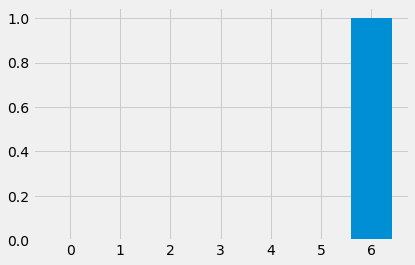

In [59]:
# get importance
importance = tuned_dt_model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

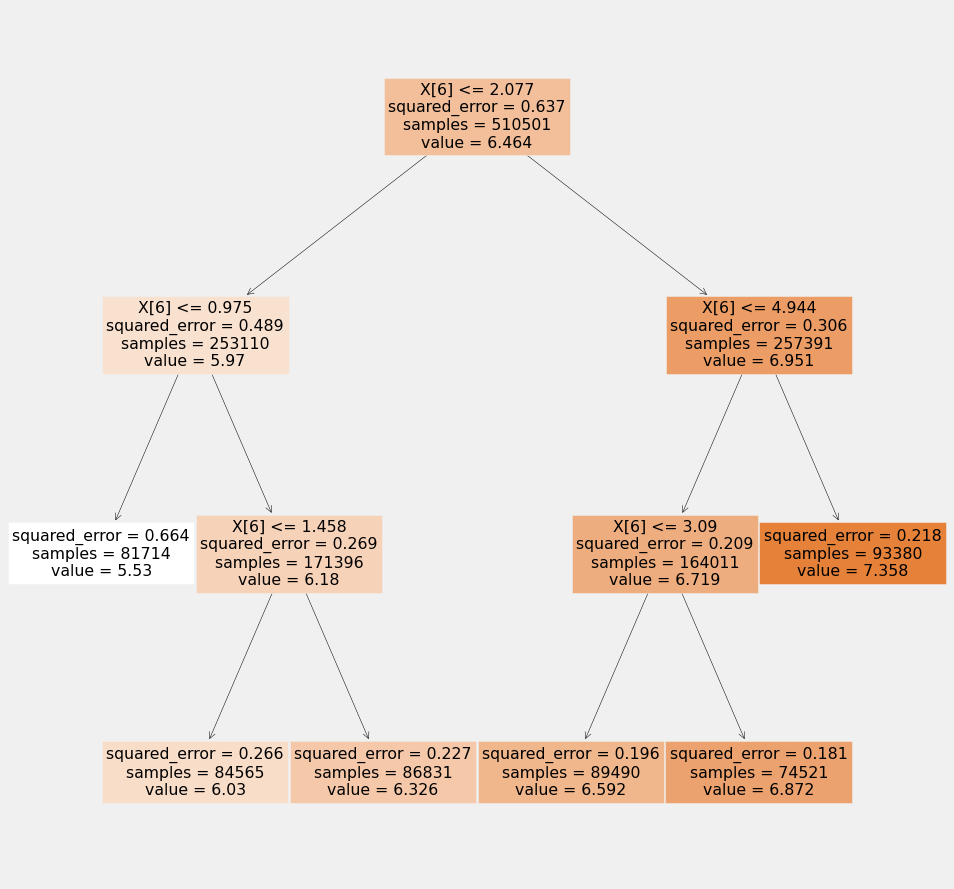

In [60]:
# Decision tree visualization
fig = plt.figure(figsize=(15,15))
tree.plot_tree(tuned_dt_model, filled=True);

#### 6) Bar plots - Train score of all model.

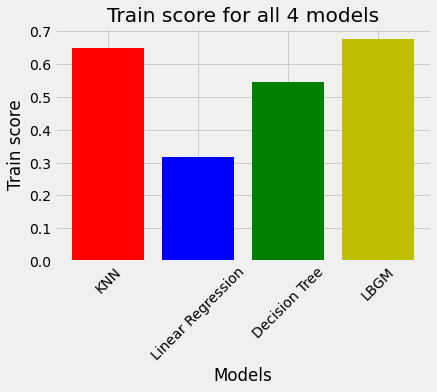

In [61]:
# Heights
train_KNN = ['knn_score_train']
train_Linear_reg = ['reg_score_train']
train_dt = ['dtm_score_train']
train_LBGM = ['LBGM_score_train']
           
# create a dataset
height = [knn_score_train,reg_score_train,dtm_score_train,LBGM_score_train]
bars = ('KNN', 'Linear Regression', 'Decision Tree', 'LBGM')
x_pos = np.arange(len(bars))

# Create bars
plt.bar(x_pos, height, color=('r','b','g','y'))

# Create labels
plt.title("Train score for all 4 models")
plt.ylabel("Train score")
plt.xlabel("Models")
# Create names on the x-axis
plt.xticks(x_pos, bars, rotation = 45)

# Show graph
plt.show()

#### Bar plots - Test score of all model.

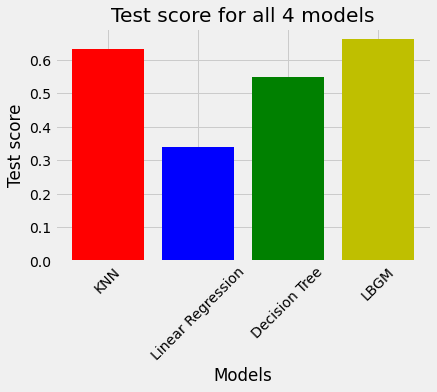

In [62]:
# Heights
test_KNN = ['knn_score_test']
test_Linear_reg = ['reg_score_test']
test_dt = ['dtm_score_test']
test_LBGM = ['LBGM_score_test']
             
# create a dataset
height = [knn_score_test,reg_score_test,dtm_score_test,LBGM_score_test]
bars = ('KNN', 'Linear Regression', 'Decision Tree', 'LBGM')
x_pos = np.arange(len(bars))

# Create bars
plt.bar(x_pos, height, color=('r','b','g','y'))

# Create labels
plt.title("Test score for all 4 models")
plt.ylabel("Test score")
plt.xlabel("Models")
# Create names on the x-axis
plt.xticks(x_pos, bars, rotation=45)

# Show graph
plt.show()